In [1]:
import pandas as pd
import deepchem as dc
from deepchem.models.optimizers import ExponentialDecay

from qsar.gan.gan_featurizer import QsarGanFeaturizer
from qsar.gan.qsar_gan import QsarGan
from qsar.gan.extract_descriptors import DescriptorsExtractor
from qsar.utils.visualizer import Visualizer

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some PyTorch models, missing a dependency. No module named 'torch_geometric'
No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.


# Data importation

In [2]:
# our dataset (183 smiles)
df = pd.read_csv('../data/unfiltered_data_smiles.csv')
data_local = df[['SMILES']]
data_local.columns = [col.lower() for col in data_local.columns]

# Tox21 Dataset: Contains bioactivity data for various chemicals in toxicity assays, used for toxicology research and safety assessments.
# https://paperswithcode.com/dataset/tox21-1
_, datasets, _ = dc.molnet.load_tox21()
data_tox21 = pd.DataFrame(data={'smiles': datasets[0].ids})

# Lipo Dataset: Provides lipophilicity data (logP values) of chemical compounds, aiding in studies of compound absorption and metabolism in pharmacology.
# https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301361/
_, datasets, _ = dc.molnet.load_lipo()
data_lipo = pd.DataFrame(data={'smiles': datasets[0].ids})

# thought of combining all datasets might maximise the GAN perf and boost the prediction
data = pd.concat([data_local, data_tox21, data_lipo], ignore_index=True)
display(data)

,smiles
0,O=C(Nc1ccc(O)cc1)C
1,ClC1(Cl)C2(Cl)C3(Cl)C4(Cl)C(Cl)(Cl)C5(Cl)C3(Cl...
2,S(=O)(=O)(N)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...
3,S(CCNC(=NC#N)NC)Cc1c(C)[nH]c[n+H]1
4,OCC
...,...
9802,Nc1scc2C(=NN(C(=O)c12)c3ccc(F)cc3)C(=O)NC4CC4
9803,O=C(NC1(CC1)C#N)[C@@H]2CCCC[C@H]2C(=O)N3CCc4[n...
9804,Cn1cnc(c1Sc2ncnc3nc[nH]c23)[N+](=O)[O-]
9805,OCCN1CCN(Cc2ccc3c(NC(=O)CC45CC6CC(CC(C6)C4)C5)...


# Determine the max atom count threshold

[02:45:13] SMILES Parse Error: syntax error while parsing: S(CCNC(=NC#N)NC)Cc1c(C)[nH]c[n+H]1
[02:45:13] SMILES Parse Error: Failed parsing SMILES 'S(CCNC(=NC#N)NC)Cc1c(C)[nH]c[n+H]1' for input: 'S(CCNC(=NC#N)NC)Cc1c(C)[nH]c[n+H]1'
[02:45:13] SMILES Parse Error: syntax error while parsing: [N+H3]C(Cc1ccccc1)C
[02:45:13] SMILES Parse Error: Failed parsing SMILES '[N+H3]C(Cc1ccccc1)C' for input: '[N+H3]C(Cc1ccccc1)C'
[02:45:13] SMILES Parse Error: syntax error while parsing: O=[SH0]1c2c(/C(=C/CC[N+H](C)C)/c3c(cccc3)C1)cccc2
[02:45:13] SMILES Parse Error: Failed parsing SMILES 'O=[SH0]1c2c(/C(=C/CC[N+H](C)C)/c3c(cccc3)C1)cccc2' for input: 'O=[SH0]1c2c(/C(=C/CC[N+H](C)C)/c3c(cccc3)C1)cccc2'
[02:45:13] SMILES Parse Error: syntax error while parsing: FC(F)(F)c1ccc(OC(CC[N+H3])c2ccccc2)cc1
[02:45:13] SMILES Parse Error: Failed parsing SMILES 'FC(F)(F)c1ccc(OC(CC[N+H3])c2ccccc2)cc1' for input: 'FC(F)(F)c1ccc(OC(CC[N+H3])c2ccccc2)cc1'
[02:45:13] SMILES Parse Error: syntax error while parsing: C

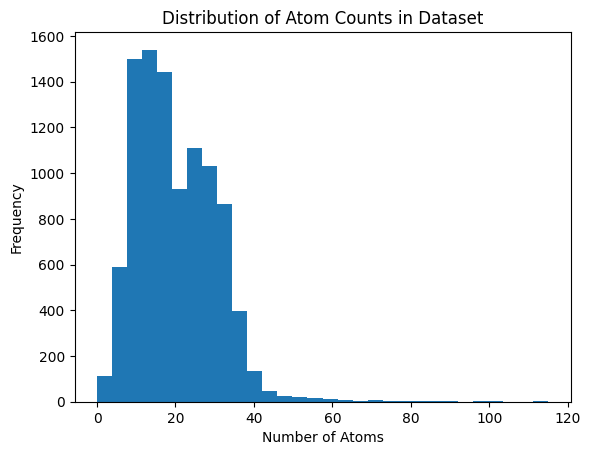

Max atom count: 36


In [3]:
featurizer = QsarGanFeaturizer()
max_atom_count, atom_counts = featurizer.determine_atom_count(smiles=data, quantile=0.95)
visualizer = Visualizer()
visualizer.display_atom_count_distribution(atom_counts)
print(f'Max atom count: {max_atom_count}')
# for simplicity, we set the max atom count to 9 as the default value in BasicMolGAN
featurizer.max_atom_count = 9

# Featurize the data

In [4]:
features = featurizer.get_features(data.copy())

[02:45:14] SMILES Parse Error: syntax error while parsing: S(CCNC(=NC#N)NC)Cc1c(C)[nH]c[n+H]1
[02:45:14] SMILES Parse Error: Failed parsing SMILES 'S(CCNC(=NC#N)NC)Cc1c(C)[nH]c[n+H]1' for input: 'S(CCNC(=NC#N)NC)Cc1c(C)[nH]c[n+H]1'
[02:45:14] SMILES Parse Error: syntax error while parsing: [N+H3]C(Cc1ccccc1)C
[02:45:14] SMILES Parse Error: Failed parsing SMILES '[N+H3]C(Cc1ccccc1)C' for input: '[N+H3]C(Cc1ccccc1)C'
[02:45:14] SMILES Parse Error: syntax error while parsing: O=[SH0]1c2c(/C(=C/CC[N+H](C)C)/c3c(cccc3)C1)cccc2
[02:45:14] SMILES Parse Error: Failed parsing SMILES 'O=[SH0]1c2c(/C(=C/CC[N+H](C)C)/c3c(cccc3)C1)cccc2' for input: 'O=[SH0]1c2c(/C(=C/CC[N+H](C)C)/c3c(cccc3)C1)cccc2'
[02:45:14] SMILES Parse Error: syntax error while parsing: FC(F)(F)c1ccc(OC(CC[N+H3])c2ccccc2)cc1
[02:45:14] SMILES Parse Error: Failed parsing SMILES 'FC(F)(F)c1ccc(OC(CC[N+H3])c2ccccc2)cc1' for input: 'FC(F)(F)c1ccc(OC(CC[N+H3])c2ccccc2)cc1'
[02:45:14] SMILES Parse Error: syntax error while parsing: C

# Train the Gan and generate data

In [5]:
gan = QsarGan(featurizer=featurizer, learning_rate=ExponentialDecay(0.001, 0.9, 5000))
generated_smiles = gan.fit_predict(features=features, epochs=128)
display(generated_smiles)

Ending global_step 767: generator average loss -13.0339, discriminator average loss 5.04381
TIMING: model fitting took 28.604 s
Generating 10000 samples


[02:45:46] non-ring atom 0 marked aromatic
[02:45:46] Explicit valence for atom # 8 O, 3, is greater than permitted
[02:45:46] Explicit valence for atom # 0 C, 10, is greater than permitted
[02:45:46] Explicit valence for atom # 0 N, 13, is greater than permitted
[02:45:46] Explicit valence for atom # 0 C, 10, is greater than permitted
[02:45:46] Explicit valence for atom # 8 O, 3, is greater than permitted
[02:45:46] Explicit valence for atom # 0 N, 13, is greater than permitted
[02:45:46] non-ring atom 0 marked aromatic
[02:45:46] Explicit valence for atom # 8 O, 4, is greater than permitted
[02:45:46] Explicit valence for atom # 8 O, 3, is greater than permitted
[02:45:46] non-ring atom 0 marked aromatic
[02:45:46] Explicit valence for atom # 4 O, 3, is greater than permitted
[02:45:46] Explicit valence for atom # 8 O, 3, is greater than permitted
[02:45:46] Explicit valence for atom # 8 O, 4, is greater than permitted
[02:45:46] Explicit valence for atom # 8 O, 5, is greater than p

# Extract Descriptors

In [6]:
data_with_descriptors = DescriptorsExtractor.extract_descriptors(generated_smiles)
display(data_with_descriptors)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,SPS
<rdkit.Chem.rdchem.Mol object at 0x0000023AAD0D5000>,4.500000,4.500000,1.500000,1.500000,0.384658,3.000,31.058,26.018,31.042199,14,...,0,0,0,0,0,0,0,0,0,3.000
<rdkit.Chem.rdchem.Mol object at 0x0000023AAD0D5070>,7.500000,7.500000,4.500000,4.500000,0.383433,2.000,31.014,30.006,31.005814,12,...,0,0,0,0,0,0,0,0,0,2.000
<rdkit.Chem.rdchem.Mol object at 0x0000023AAD0D50E0>,7.000000,7.000000,7.000000,7.000000,0.378296,2.000,31.998,31.998,31.989829,12,...,0,0,0,0,0,0,0,0,0,2.000
<rdkit.Chem.rdchem.Mol object at 0x0000023AAD0D5150>,5.309028,5.309028,0.125000,0.125000,0.504352,35.250,112.172,100.076,112.088815,46,...,0,0,0,0,0,0,0,0,0,35.250
<rdkit.Chem.rdchem.Mol object at 0x0000023AAD0D51C0>,2.000000,2.000000,2.000000,2.000000,0.372786,3.000,30.070,24.022,30.046950,14,...,0,0,0,0,0,0,0,0,0,3.000
<rdkit.Chem.rdchem.Mol object at 0x0000023AAD0D5230>,7.000000,7.000000,1.000000,1.000000,0.385284,3.000,32.042,28.010,32.026215,14,...,0,0,0,0,0,0,0,0,0,3.000
<rdkit.Chem.rdchem.Mol object at 0x0000023AAD0D52A0>,5.059028,5.059028,0.013889,0.013889,0.505355,35.250,113.160,102.072,113.084064,46,...,0,0,0,0,0,0,0,0,0,35.250
<rdkit.Chem.rdchem.Mol object at 0x0000023AAD0D5310>,11.253699,11.253699,0.126852,0.126852,0.596559,12.875,117.167,105.071,117.095378,48,...,0,0,0,0,0,0,0,0,0,12.875
<rdkit.Chem.rdchem.Mol object at 0x0000023AAD0D5380>,5.489583,5.489583,0.236111,0.236111,0.506074,38.250,114.188,100.076,114.104465,48,...,0,0,0,0,0,0,0,0,0,38.250
<rdkit.Chem.rdchem.Mol object at 0x0000023AAD0D53F0>,9.152778,9.152778,0.517361,-0.986111,0.540028,35.250,115.132,106.060,115.063329,46,...,0,0,0,0,0,0,0,0,0,35.250


# Display the generated molecules

In [7]:
visualizer.draw_generated_molecules(generated_smiles)